# Collaborative filtering example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dir_name = '/Users/mbeckert/Documents/code/insight_beer/data/'
beer_df = pd.read_csv(dir_name + 'beer_reviews.csv')

## Trim the data down
### remove the users and beers with highly sparse review history

In [101]:
beers = beer_df.groupby('beer_beerid')['beer_beerid'].count()
beers = beers.index[beers.sort_values() > 10]
beer_df = beer_df[beer_df.beer_beerid.isin(beers)]

In [102]:
users = beer_df.groupby('review_profilename')['beer_beerid'].count()
users = users.index[users.sort_values() > 150]
beer_df = beer_df[beer_df.review_profilename.isin(users)]

In [103]:
len(beer_df)

1193

In [104]:
del users, beers

## Some exploration after the manipulation

In [147]:
n_users = beer_df.review_profilename.unique().shape[0]
n_items = beer_df.beer_beerid.unique().shape[0]
print(str(n_users) + ' users')
print(str(n_items) + ' beers')

33388 users
66055 beers


We have narrowed everything down to just a few popular users and beers

## Now we need to replace the str names to numerical data for indexing

In [148]:
beer_df = beer_df[['review_profilename', 'beer_beerid', 'review_overall']]

In [ ]:
exch = dict(zip(beer_df['review_profilename'].unique(), np.arange(len(beer_df['review_profilename'].unique()))))
beer_df.review_profilename = beer_df.review_profilename.replace(exch)

In [ ]:
exch = dict(zip(beer_df['beer_beerid'].unique(), np.arange(len(beer_df['beer_beerid'].unique()))))
beer_df.beer_beerid = beer_df.beer_beerid.replace(exch)

In [ ]:
beer_df['review_overall'] = beer_df['review_overall'].replace({0.0:0.1})

In [ ]:
del exch

## Now we produce the matrix of users and beers

In [112]:
ratings = np.zeros((n_users, n_items))
# ratings.fill(np.nan)
for row in beer_df.itertuples():
    ratings[row[1], row[2]] = row[3]
ratings

array([[4. , 3.5, 3.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 4.5, 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

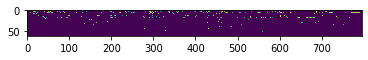

In [113]:
plt.imshow(ratings)

In [114]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity/= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 2.45%


## Produce training and testing data sets

In [121]:
# Custom train_test_split written by EvanRosenthal

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=1, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [122]:
train, test = train_test_split(ratings)

# Collaborative filtering!
## cosine similarity

In [130]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in np.arange(ratings.shape[axmax]):
        for uprime in np.arange(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in np.arange(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [131]:
%timeit slow_similarity(train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


5.51 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
%timeit fast_similarity(train, kind='user')

89.7 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [133]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print(item_similarity[:4, :4])

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 5.00000000e-11]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 5.71428571e-11]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 5.71428571e-11]
 [5.00000000e-11 5.71428571e-11 5.71428571e-11 1.00000000e+00]]


In [134]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in np.arange(ratings.shape[0]):
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in np.arange(ratings.shape[0]):
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [135]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

302 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [136]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

150 µs ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [137]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [139]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 14.534268474732773
Item-based CF MSE: 14.741639117643565


In [140]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in np.arange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in np.arange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in np.arange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in np.arange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [142]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k User-based CF MSE: 14.53426922082146


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


Top-k Item-based CF MSE: 14.875053586071692


In [143]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)] 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);